In [22]:
# pip install sklearn

In [91]:
import mne
import os

from skimage.restoration import denoise_wavelet
import warnings
warnings.filterwarnings('ignore')
from os.path import abspath
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from mne.time_frequency import psd_welch
from tqdm import tqdm
import itertools
import pickle 
from multiprocessing import Process
file_path="/media/kashraf/Elements/Dissertation/data/CVPIA_eeg/Data/Filtered/S2/"
filename=os.listdir(file_path)
path_montage="/media/kashraf/Elements/data_gen_may_2021/montage/"
montage=mne.channels.read_montage(path_montage+"//"+"neuroscan64ch.loc")
data1=mne.io.read_raw_cnt(file_path+"S02_v Data.cnt",montage=montage, 
                         preload=True,verbose=False);

good_ch= mne.pick_channels(data1.info['ch_names'], include=[],
                        exclude=["EKG","EMG",'VEO','HEO','Trigger'])
mne.pick_info(data1.info,sel=good_ch,copy=False,verbose=False)
data1.set_montage(montage)
mne.pick_info(data1.info,sel=good_ch,copy=False)
data1.set_montage(montage)
from sklearn.preprocessing import MinMaxScaler as scaler

In [24]:
info = data1.info
path = "/media/kashraf/Elements/Dissertation/data/"
data = pd.read_csv(os.path.join(path,"Pouya_psd_multichannel.csv"),header=None)
data.head()

,0,1,2,3,4,5,6,7,8,9,...,1335,1336,1337,1338,1339,1340,1341,1342,1343,1344
0,-0.168972,-0.178322,-0.095154,-0.051145,-0.024695,0.006822,0.146601,0.049728,-0.030761,-0.030718,...,0.784023,0.506616,0.657810,0.726842,0.044563,0.169059,0.267928,0.438069,-0.028650,1
1,1.150855,1.023013,0.482823,1.808277,1.681753,0.369737,1.162185,2.948635,1.297460,1.556453,...,0.240170,0.612654,0.860099,0.984312,0.763681,1.023541,0.478984,0.591697,-0.018466,1
2,-0.239892,-0.286383,-0.117660,-0.041761,0.045529,0.350156,0.757991,0.672565,0.261040,0.249775,...,0.320247,1.314314,1.746596,1.972543,0.145621,0.192455,0.480254,1.275407,-0.019574,1
3,0.616870,0.935586,0.557368,0.506930,1.129597,0.015468,-0.019766,0.371247,0.159066,0.341238,...,2.490612,1.543079,1.936653,2.168959,1.326236,1.985246,1.321501,1.634900,-0.008216,1
4,-0.203458,-0.082669,0.101029,0.022260,0.554096,0.258584,0.295721,0.092840,0.010436,0.063246,...,1.729174,1.035423,1.461515,1.546399,0.365488,0.338945,1.001988,1.224796,-0.013884,1


In [94]:
cl2_data = scaler().fit_transform(data[data[1344]==1])
cl4_data = scaler().fit_transform(data[data[1344]==2])
cl6_data = scaler().fit_transform(data[data[1344]==3])
cl8_data = scaler().fit_transform(data[data[1344]==4])
ch_loc= pd.read_csv(os.path.join(path,"Channel_location.csv"),header=None)
xy_cords=ch_loc.iloc[:,:2].values
xy_cords[:,].shape

(64, 2)

In [95]:
cl2_data

array([[1.13937786e-02, 1.38991172e-02, 3.31989140e-03, ...,
        8.05361475e-02, 1.16393012e-04, 0.00000000e+00],
       [7.01087687e-02, 8.75917879e-02, 1.62417763e-02, ...,
        9.47173077e-02, 3.26146881e-04, 0.00000000e+00],
       [8.23878834e-03, 7.27040290e-03, 2.81672593e-03, ...,
        1.57829466e-01, 3.03311625e-04, 0.00000000e+00],
       ...,
       [1.50146472e-02, 1.78907528e-02, 4.35197603e-03, ...,
        1.63358243e-02, 7.59288061e-05, 0.00000000e+00],
       [7.24130452e-03, 6.21743707e-03, 1.67877204e-03, ...,
        1.37547153e-02, 7.41351798e-05, 0.00000000e+00],
       [2.05234608e-02, 2.03919670e-02, 6.03576079e-03, ...,
        9.28641356e-03, 2.06670705e-05, 0.00000000e+00]])

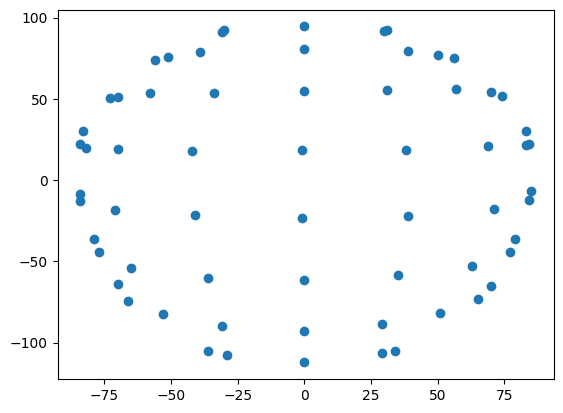

In [26]:
plt.scatter(xy_cords[:,0],xy_cords[:,1])

In [96]:
# p="/media/kashraf/Elements/Dissertation/data/pouya_topomaps/beta/"
# for i in range(7):
#     os.mkdir(os.path.join(p,"interv_"+str(i+1),"cl2"))
#     os.mkdir(os.path.join(p,"interv_"+str(i+1),"cl4"))
#     os.mkdir(os.path.join(p,"interv_"+str(i+1),"cl6"))
#     os.mkdir(os.path.join(p,"interv_"+str(i+1),"cl8"))

In [101]:
cl2_data.shape

(757, 1345)

In [102]:
def generate_intervaldata(data, t_step):
    int_data= data[:,t_step:t_step+192]
    theta = int_data[:,:64]
    alpha = int_data[:,64:128]
    beta  = int_data[:,128:192]
    
    return theta, alpha,beta

# theta,alpha, beta= generate_intervaldata(cl2_data,0)
# beta.shape
# intps=['bilinear', 'bicubic', 'spline16', 'spline36', 'hanning', 'hamming', 'hermite', 'kaiser', 'quadric', 'catrom', 'gaussian', 'bessel', 'mitchell',
#        'sinc', 'lanczos', 'blackman']

In [105]:
def topo_gen(dest_path,cl_data,interval, cl_level):
    theta,alpha, beta= generate_intervaldata(cl2_data,interval)
    for i in (range(theta.shape[0])):
        
        fig_theta=mne.viz.plot_topomap(theta[i,],show=False,image_interp='bilinear',
                                       sensors=False,cmap="Greens",pos=xy_cords,contours=False)

        fig_alpha=mne.viz.plot_topomap(alpha[i,],show=False,image_interp='bilinear',
                                       sensors=False,cmap="Blues",pos=xy_cords,contours=False)
#         plt.show("off")
        fig_beta=mne.viz.plot_topomap(beta[i,],show=False,image_interp='bilinear',
                                       sensors=False,cmap='Reds',pos=xy_cords,contours=False)
#         plt.show("off")
            

        fig_theta[0].get_figure().savefig(os.path.join(dest_path,"theta","interv_"+str(interval+1),cl_level,"theta_"+str(i+1)),bbox_inches='tight', transparent=True,
                                         pad_inches=0)
        fig_alpha[0].get_figure().savefig(os.path.join(dest_path,"alpha","interv_"+str(interval+1),cl_level,"alpha_"+str(i+1)),bbox_inches='tight', transparent=True,
                                         pad_inches=0)
        fig_beta[0].get_figure().savefig(os.path.join(dest_path,"beta","interv_"+str(interval+1),cl_level,"beta_"+str(i+1)),bbox_inches='tight', transparent=True,
                                      pad_inches=0)
        plt.close("all")
    

In [109]:
int_path= "/media/kashraf/Elements/Dissertation/data/pouya_topomaps/"
for i in tqdm(range(7)):
    topo_gen(int_path,cl8_data,i,"cl8")
    plt.show("off")

100%|████████████████████████████████████████████| 7/7 [26:56<00:00, 231.00s/it]


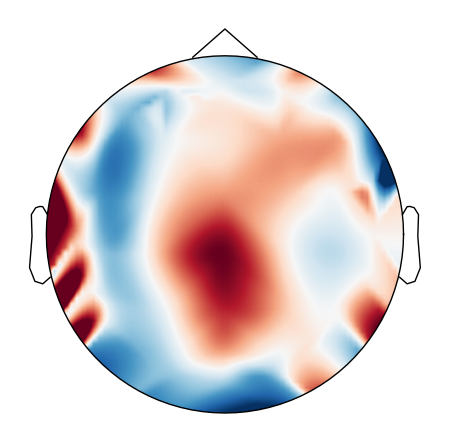

(<matplotlib.image.AxesImage at 0x7f5225e6f1c0>,
 <matplotlib.contour.QuadContourSet at 0x7f5225e6f2e0>)

In [28]:
mne.viz.plot_topomap(beta.iloc[0,],image_interp='bilinear',sensors=False,pos=xy_cords,contours=False)

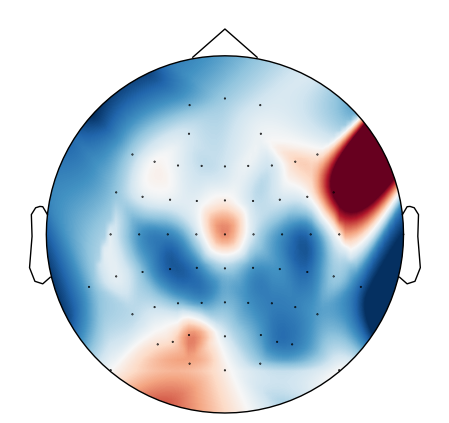

(<matplotlib.image.AxesImage at 0x7f2dea6f1a90>,
 <matplotlib.contour.QuadContourSet at 0x7f2dea6ec310>)

In [61]:
mne.viz.plot_topomap(alpha.iloc[0,],pos=info,contours=False)
plt.savefig()